# Basal Topography Inversion Example: HO Luggye Glacier Flowline Model (steady state)

This notebook demonstrates how to invert for basal topography along a glacier flowline using observational data from Lugge Glacier. We assume the observed surface elevation represents a steady-state profile governed by Blatter-Pattyn (Higher Order) Approximation.

The inversion follows the approach of [van Pelt et al. (2013)](https://tc.copernicus.org/articles/7/987/2013/), iteratively adjusting the bed to minimize the surface misfit after forward modeling.

The procedure is implemented using the [centerflow_extruded](https://github.com/chrismiele/glimmer/blob/main/1D_modelling/centerflow_extruded.ipynb) package, which is built on top of Firedrake and icepack. 

## Imports

In [1]:
from firedrake import *
import icepack
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import numpy as np
import os
import tqdm

os.chdir('/eejit/home/bezu0001/icepack/notebooks/GLIMMER/1D_modelling')
from centerflow_extruded import *

## Paths

In [2]:
rgiid_6 = '15.02373' #rgiid from 6.0 (for most data)
rgiid_7 = '15-09534' #rgiid from 7.0 (for outlines)

base_path = '/eejit/home/bezu0001/data/'
centerline_path = base_path + 'centerlines/RGI2000-v7.0-L-15_south_asia_east/RGI2000-v7.0-L-15_south_asia_east.shp'
outline_path = base_path + 'outlines/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp'
velocity_path = base_path + f'velocity/{rgiid_7}/MedianVelocity_2006.tif'
dem_path = base_path + f'elevation/farinotti/surface_DEM_RGI60-{rgiid_6}.tif'
thickness_path = base_path + f'thickness/farinotti_ensemble/RGI60-{rgiid_6}_thickness.tif'
smb_path = base_path + 'smb/karma/prf_glacier_ctl.csv'

## Load and adjust data

Because ```icepack``` assumes that the waterline is at sea level, things run more smoothly if we shift the dem downward so that 0 is lake level. Meanwhile, surface mass balance measurements are too negative to support much forward modeling, so these are shifted as well. Finally, higher-order model convergence struggles with bumpy data, so smoothing is performed on all input datasets, using ```smooth_function```, which is defined in [centerflow_extruded](https://github.com/chrismiele/glimmer/blob/main/1D_modelling/centerflow_extruded.ipynb). 

In [3]:
n_cells = 50

mesh = centerline_mesh(rgiid = '15-09534', centerline_path = centerline_path, outline_path = outline_path, n_cells = n_cells)
cell_size = int(mesh.length/n_cells)
print(f'average cell size = {cell_size} m')

thickness = map_to_mesh(mesh = mesh, data_path = thickness_path)
dem = map_to_mesh(mesh = mesh, data_path = dem_path)
smb = map_to_mesh(mesh = mesh, data_path = smb_path, key_value = ' altitude', key_dataset = dem, data_value = 'ave_mb')
velocity = map_to_mesh(mesh = mesh, data_path = velocity_path, ice_free_value = 0)

Q = dem.function_space() #function space for depth-invariant quantities
V = FunctionSpace(mesh.mesh, 'CG', 1, vfamily = 'GL', vdegree = 2) #function space for quantities which vary with depth
x, ζ = SpatialCoordinate(mesh.mesh) #ζ ranges from 0 (base) to 1 (surface)
X = mesh.mesh._base_mesh.coordinates.dat.data_ro.flatten() #x coords in array form

freeboard = 10
smoothing_params = {'window': 3*cell_size, 'mesh': mesh}

smb_adjusted = Function(Q).project(smb + 3)
smb_adjusted = smooth_function(function = smb_adjusted, **smoothing_params)
dem = Function(Q).project(dem - dem.at(mesh.length, 1/2) + freeboard)
dem = smooth_function(function = dem, **smoothing_params)
thickness = smooth_function(function = thickness, **smoothing_params)

velocity = smooth_function(function = velocity, **smoothing_params)
velocity_shape = (1 - (1 - ζ)**4) #the vertical velocity profile follows this shape, assuming n = 3
velocity_shape = 1e-10
u = Function(V).project(velocity_shape*velocity) #use this velocity for our boundary condition

average cell size = 171 m


## Initialize the flow model

Depending on basal topography and glacier thickness evolution, the glacier may at times become ungrounded. To account for this, we define a new basal friction function which decreases with proximity to flotation. For this notebook, we assume the lake has the density of seawater, allowing ```icepack.compute_surface``` to straightforwardly determine where the glacier begins floating. 

In [4]:
def basal_friction(**kwargs): #function to scale the basal friction by fraction above flotation
    H = kwargs['thickness']
    s = kwargs['surface']
    u = kwargs['velocity']
    C = kwargs['friction']

    b = s - H
    ϱ = icepack.constants.ice_density/icepack.constants.water_density 

    flotation_surface = (1 - ϱ)*H #given the current thickness, this is the hypothetical surface elevation which would float the shelf
    h_af = s - flotation_surface #height above flotation
    frac_af = firedrake.min_value(h_af/H, 1) #fraction above flotation, capped at unity
    
    return icepack.models.hybrid.bed_friction(velocity = u, friction = C*frac_af)

T = 273.15 - 5 #ice temperature (K), assumed isothermal
A = Constant(icepack.rate_factor(T))
C = Constant(0.1)

model_opts = {'dirichlet_ids': [1]}
flow_model = icepack.models.HybridModel(friction = basal_friction)
flow_solver = icepack.solvers.FlowSolver(flow_model, **model_opts)

## Invert for basal topography

In [5]:
inversion_params = {
    'model': flow_model,
    'solver': flow_solver,
    'mesh': mesh,
    'fluidity': A,
    'friction': C,
}
    
inversion = solve_bed(K = 0.2, num_iterations = 40, timestep = 1/10, model_time = 10, surface = dem,
                      thickness_guess = Constant(200), velocity = u, accumulation = smb_adjusted, 
                      **inversion_params)

100%|██████████| 40/40 [02:10<00:00,  3.27s/it]


## Visualize the results

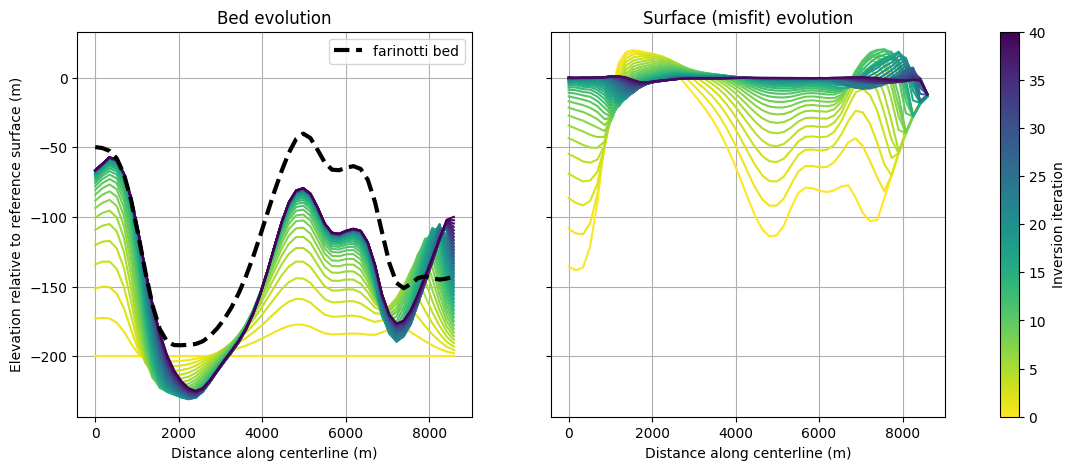

In [6]:
s_ref_array = dem.dat.data_ro.copy()
farinotti_ref_array = -thickness.dat.data_ro.copy()

# Evolution data
bed_evolution = inversion.bed_evolution
surface_evolution = inversion.surface_evolution

# Setup colormap
N = len(bed_evolution)
cmap = plt.get_cmap('viridis_r')
norm = Normalize(vmin=0, vmax=N - 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: Bed evolution
for i, entry in enumerate(bed_evolution):
    axes[0].plot(X, entry - s_ref_array, color=cmap(norm(i)))
axes[0].plot(X, farinotti_ref_array, color = 'k', linestyle = 'dashed', linewidth = 3, label = 'farinotti bed')
axes[0].set_title('Bed evolution')
axes[0].set_xlabel('Distance along centerline (m)')
axes[0].set_ylabel('Elevation relative to reference surface (m)')
axes[0].legend()
axes[0].grid()

# Right: Surface misfit evolution
for i, entry in enumerate(surface_evolution):
    axes[1].plot(X, entry - s_ref_array, color=cmap(norm(i)))
axes[1].set_title('Surface (misfit) evolution')
axes[1].set_xlabel('Distance along centerline (m)')
axes[1].grid()

# Shared colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', label='Inversion iteration')
plt.show()

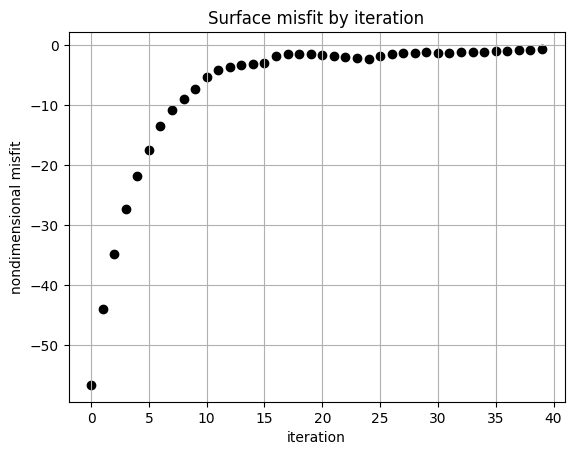

In [7]:
plt.figure()
plt.title('Surface misfit by iteration')
plt.scatter(range(len(inversion.misfits)), inversion.misfits, color='k')
plt.ylabel('nondimensional misfit')
plt.xlabel('iteration')
plt.grid(True, which='both')
# plt.ylim(0) 
plt.show()

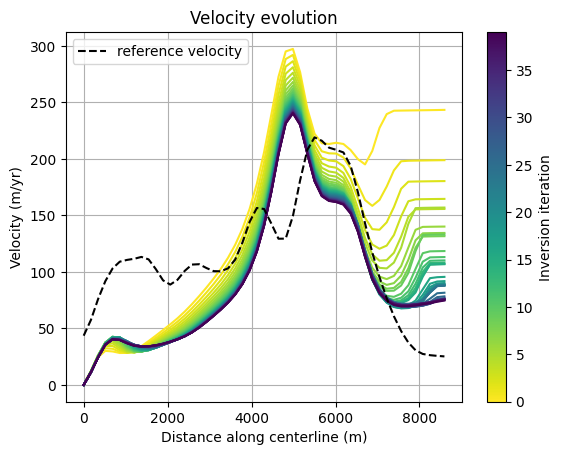

In [8]:
velocity_ref = velocity.dat.data_ro.copy()

# Evolution data
velocity_evolution = inversion.velocity_evolution

# Setup colormap
N = len(velocity_evolution)
cmap = plt.get_cmap('viridis_r')
norm = Normalize(vmin = 0, vmax = N - 1)

fig, axes = plt.subplots()

# Left: Bed evolution
for i, entry in enumerate(velocity_evolution):
    plt.plot(X, entry, color = cmap(norm(i)))
plt.title('Velocity evolution')
plt.xlabel('Distance along centerline (m)')
plt.ylabel('Velocity (m/yr)')
plt.plot(X, velocity_ref, color = 'k', linestyle = 'dashed', label = 'reference velocity')
plt.legend()
plt.grid()

sm = ScalarMappable(norm = norm, cmap = cmap)
fig.colorbar(sm, ax = axes, orientation = 'vertical', label = 'Inversion iteration')
plt.show()

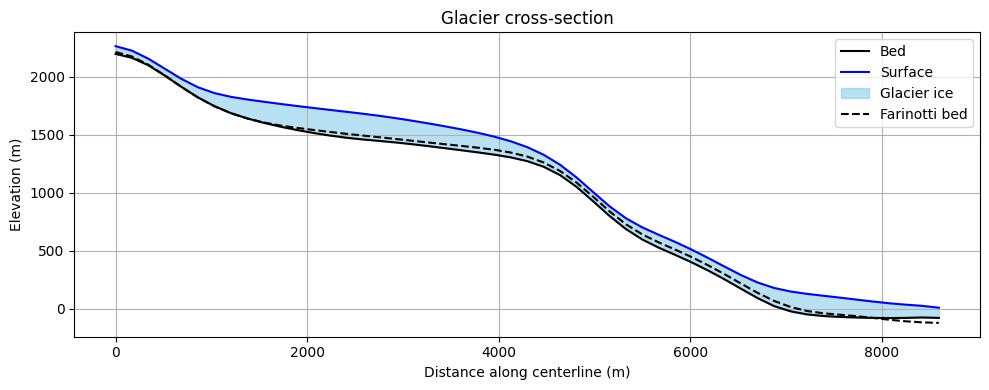

In [9]:
base = surface_evolution[-1] - inversion.thickness_evolution[-1]
surface = surface_evolution[-1]
bed = bed_evolution[-1]
farinotti_bed_array = s_ref_array + farinotti_ref_array


plt.figure(figsize = (10, 4))
plt.plot(X, bed, color = 'black', label = 'Bed')
plt.plot(X, surface, color = 'blue', label = 'Surface')
plt.fill_between(X, base, surface, color = 'skyblue', alpha = 0.6, label = 'Glacier ice')
plt.plot(X, farinotti_bed_array, color = 'k', linestyle = 'dashed', label = 'Farinotti bed')

plt.xlabel('Distance along centerline (m)')
plt.ylabel('Elevation (m)')
plt.title('Glacier cross-section')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()